### Joslin

* [Dataset]

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import process_labels,split_data#preprocess_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_cpu_metrics import train_early_fusion, train_late_fusion

In [2]:
PATH = 'Embeddings/joslin/'
COLUMN = 'embeddings'

In [3]:
text_path, images_path = 'text_embeddings.csv', 'Embeddings_dinov2_base.csv' # os.listdir(PATH)

## Get data

### Text

In [10]:
text = pd.read_csv(os.path.join(PATH, text_path))
text

,ID,EYE_DR,text,DR_2,DR_3,split,embeddings
0,67870,2,An image from the left eye of a female patien...,1,1,train,"[0.8949114084243774, 0.6178004741668701, -1.34..."
1,19446,2,An image from the left eye of a female patien...,1,1,train,"[1.0349855422973633, 1.2772152423858643, -1.71..."
2,113968,2,An image from the right eye of a male patient...,1,1,train,"[0.7820802927017212, 0.5888915657997131, -0.89..."
3,50528,1,An image from the right eye of a male patient...,1,1,train,"[0.9266375303268433, 1.2518030405044556, -1.40..."
4,91254,0,An image from the right eye of a male American...,0,0,train,"[1.0237936973571777, 1.0459136962890625, -0.75..."
...,...,...,...,...,...,...,...
24095,148958,1,"An image from the left eye of a male patient,...",1,1,train,"[0.9834482073783875, 1.3777140378952026, -1.40..."
24096,96198,0,An image from the right eye of a no sex report...,0,0,train,"[1.0272547006607056, 1.4537794589996338, 0.309..."
24097,82724,2,An image from the left eye of a female White p...,1,1,train,"[0.5230445861816406, 0.7840505838394165, -1.13..."
24098,173196,1,An image from the left eye of a female patien...,1,1,train,"[0.9105090498924255, 1.2843393087387085, -1.58..."


### Images

In [11]:
images = pd.read_csv(os.path.join(PATH, images_path))
images.head()

,ImageName,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,122786.jpeg,-1.659120,2.434443,5.408528,-1.473753,-1.231571,-1.579182,0.310355,0.089211,-2.054411,...,-0.834506,-1.625948,-0.832199,0.383083,3.018108,-0.377753,3.330745,-0.877753,0.706453,-0.888934
1,108083.jpeg,0.649771,2.682362,3.609813,-0.099313,-3.025293,-1.844079,0.110555,1.285531,-3.551425,...,-1.258714,-1.734028,-0.291844,0.766295,3.141811,-0.881183,0.988453,-1.971897,0.635810,-2.960828
2,139103.jpeg,-0.452875,1.959501,5.043268,-1.375569,-2.404718,-0.326342,0.193852,-1.271304,-2.489283,...,-0.552394,-2.835432,0.370812,-0.378938,3.269454,-0.024993,2.338004,-1.397426,1.011528,-2.073067
3,104950.jpeg,0.243488,1.284947,3.641525,-1.265688,-1.907023,-1.053229,0.491267,-0.739931,-1.183857,...,-0.259700,-3.011966,-0.380113,0.168580,3.681773,0.684641,3.809679,-1.039821,1.166576,-1.322446
4,140898.jpeg,0.992673,1.722367,3.338633,-0.978513,-2.407126,-1.316537,1.006404,0.145190,-3.242617,...,-0.961301,-2.410475,0.398771,-1.165674,3.625564,-0.225109,2.984762,-1.122606,-0.683079,-2.567407


### Merge and preprocess the datasets

In [6]:
def rename_image_embeddings(df):
    """
    Rename columns in a DataFrame for image embeddings.

    Args:
    - df (pd.DataFrame): The DataFrame containing columns to be renamed.

    Returns:
    pd.DataFrame: The DataFrame with renamed columns.

    Example:
    df_renamed = rename_image_embeddings(df)
    """
    df.columns = [f'image_{int(col)}' if col.isdigit() else col for col in df.columns]

    return df


# Preprocess and merge the dataframes
def preprocess_data(text_data, image_data, text_id="image_id", image_id="ImageName", embeddings_col = 'embeddings'):
    """
    Preprocess and merge text and image dataframes.

    Args:
    - text_data (pd.DataFrame): DataFrame containing text data.
    - image_data (pd.DataFrame): DataFrame containing image data.
    - text_id (str): Column name for text data identifier.
    - image_id (str): Column name for image data identifier.
    - embeddings_col (str): Column name for embeddings data.

    Returns:
    pd.DataFrame: Merged and preprocessed DataFrame.

    Steps:
    1. Process text and image embeddings.
    2. Convert image_id and text_id values to integers.
    3. Merge dataframes using image_id.
    4. Drop unnecessary columns.

    Example:
    merged_df = preprocess_data(text_df, image_df)
    """
    text_data = process_embeddings(text_data, embeddings_col)
    image_data = rename_image_embeddings(image_data)
    
    # Remove file extension from image_id
    if text_data[text_id].dtype != int:
        text_data[text_id] = text_data[text_id].apply(lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else x.split('.')[0])
    if image_data[image_id].dtype != int:
        image_data[image_id] = image_data[image_id].apply(lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else x.split('.')[0])
    #text_data[text_id] = text_data[text_id].apply(lambda x: x.split('.')[0])
    #image_data[image_id] = image_data[image_id].apply(lambda x: x.split('.')[0])

    # Merge dataframes using image_id
    df = pd.merge(text_data, image_data, left_on=text_id, right_on=image_id)

    # Drop unnecessary columns
    df.drop([image_id, text_id], axis=1, inplace=True)

    return df

def process_embeddings(df, col_name):
    """
    Process embeddings in a DataFrame column.

    Args:
    - df (pd.DataFrame): The DataFrame containing the embeddings column.
    - col_name (str): The name of the column containing the embeddings.

    Returns:
    pd.DataFrame: The DataFrame with processed embeddings.

    Steps:
    1. Convert the values in the specified column to lists.
    2. Extract values from lists and create new columns for each element.
    3. Remove the original embeddings column.

    Example:
    df_processed = process_embeddings(df, 'embeddings')
    """

     # Step 1: Check if values are already lists
    if isinstance(df[col_name].iloc[0], list):
        embeddings_df = pd.DataFrame(df[col_name].to_list(), columns=[f"text_{i+1}" for i in range(len(df[col_name].iloc[0]))])
    else:
        # No further processing needed
        return df
    
    # Remove the original "embeddings" column and concatenate new columns
    df = pd.concat([df, embeddings_df], axis=1).drop(columns=[col_name])
    
    return df

df = preprocess_data(text, images, "ID", "ImageName")
df.drop(columns='text', inplace=True)
df.DR_3 = df.DR_3.astype(str)
df.to_csv(os.path.join(PATH, 'embeddings.csv'), index=False)
df.head()

,EYE_DR,DR_2,DR_3,split,embeddings,image_0,image_1,image_2,image_3,image_4,...,image_758,image_759,image_760,image_761,image_762,image_763,image_764,image_765,image_766,image_767
0,2,1,1,train,"[0.8949114084243774, 0.6178004741668701, -1.34...",-0.194614,1.551416,3.167456,-0.659470,-3.600515,...,-0.944469,-2.479345,1.044819,-0.927856,2.788126,-0.253598,2.477110,-1.387924,0.215489,-1.956565
1,2,1,1,train,"[1.0349855422973633, 1.2772152423858643, -1.71...",-0.470752,1.054596,3.669757,-1.418045,-4.069333,...,-0.883426,-3.587547,1.490011,-1.364606,3.183201,1.098254,-0.005725,-0.674996,0.248989,-0.252234
2,2,1,1,train,"[0.7820802927017212, 0.5888915657997131, -0.89...",-0.835265,3.174603,4.931487,-1.338317,-2.762759,...,-0.422742,-2.356540,-0.535080,-0.605720,3.513042,-0.184934,2.935225,-1.445802,0.542226,-1.853525
3,1,1,1,train,"[0.9266375303268433, 1.2518030405044556, -1.40...",0.017145,1.760327,2.978067,-1.162380,-3.456157,...,-0.224281,-3.664709,0.584984,-1.438270,1.985970,-0.380472,3.309748,-1.593815,-0.000337,-2.685765
4,0,0,0,train,"[1.0237936973571777, 1.0459136962890625, -0.75...",-0.589794,0.591627,3.818357,-1.180251,-1.806679,...,0.128623,-1.136903,1.795039,0.138323,1.936613,0.467842,1.756278,0.596016,-0.994163,-0.204926


## Data Preparation

In [7]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = 'DR_3'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train Shape: (18815, 773)
Test Shape: (4705, 773)


In [9]:
text_columns

[]

### Models

In [8]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
Model Memory Usage: 0.38 MB
The number of parameters of the model are: 98946


STAGE:2024-03-19 16:21:15 3013688:3013688 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


Epoch 1/50 - Test Accuracy: 0.5782, macro-f1: 0.5711
Epoch 1/50 - Training Time: 10.42 seconds | Inference Time: 1.49 seconds
Epoch 2/50 - Test Accuracy: 0.5975, macro-f1: 0.4640
Epoch 2/50 - Training Time: 2.82 seconds | Inference Time: 1.56 seconds
Epoch 3/50 - Test Accuracy: 0.5536, macro-f1: 0.5461
Epoch 3/50 - Training Time: 2.32 seconds | Inference Time: 1.61 seconds
Epoch 4/50 - Test Accuracy: 0.5483, macro-f1: 0.5315
Epoch 4/50 - Training Time: 2.59 seconds | Inference Time: 1.54 seconds
Epoch 5/50 - Test Accuracy: 0.5888, macro-f1: 0.5157
Epoch 5/50 - Training Time: 2.53 seconds | Inference Time: 1.51 seconds
Epoch 6/50 - Test Accuracy: 0.5308, macro-f1: 0.5164
Epoch 6/50 - Training Time: 2.08 seconds | Inference Time: 1.40 seconds
Epoch 7/50 - Test Accuracy: 0.5413, macro-f1: 0.5228
Epoch 7/50 - Training Time: 2.81 seconds | Inference Time: 1.41 seconds
Epoch 8/50 - Test Accuracy: 0.5589, macro-f1: 0.5338
Epoch 8/50 - Training Time: 2.47 seconds | Inference Time: 1.57 seconds

STAGE:2024-03-19 16:24:56 3013688:3013688 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-03-19 16:24:57 3013688:3013688 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                   DataParallel.forward        44.03%       66.174s        51.06%       76.745s      34.109ms           0 b           0 b       1.04 Gb    -172.68 Mb          2250  
                                         training_batch         2.68%        4.032s        46.10%       69.282s      38.490ms          24 b           0 b    -450.85 Mb    -979.67 Mb          1800  
enumerate

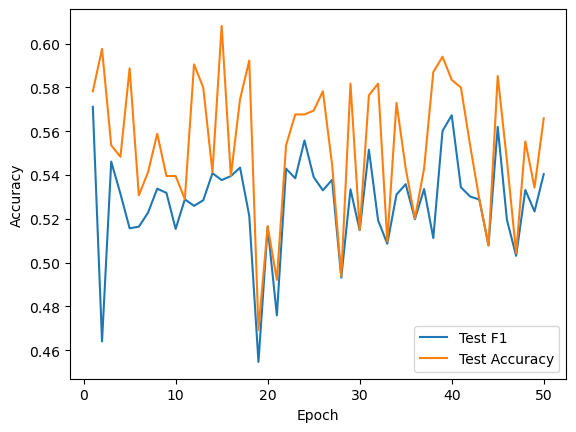

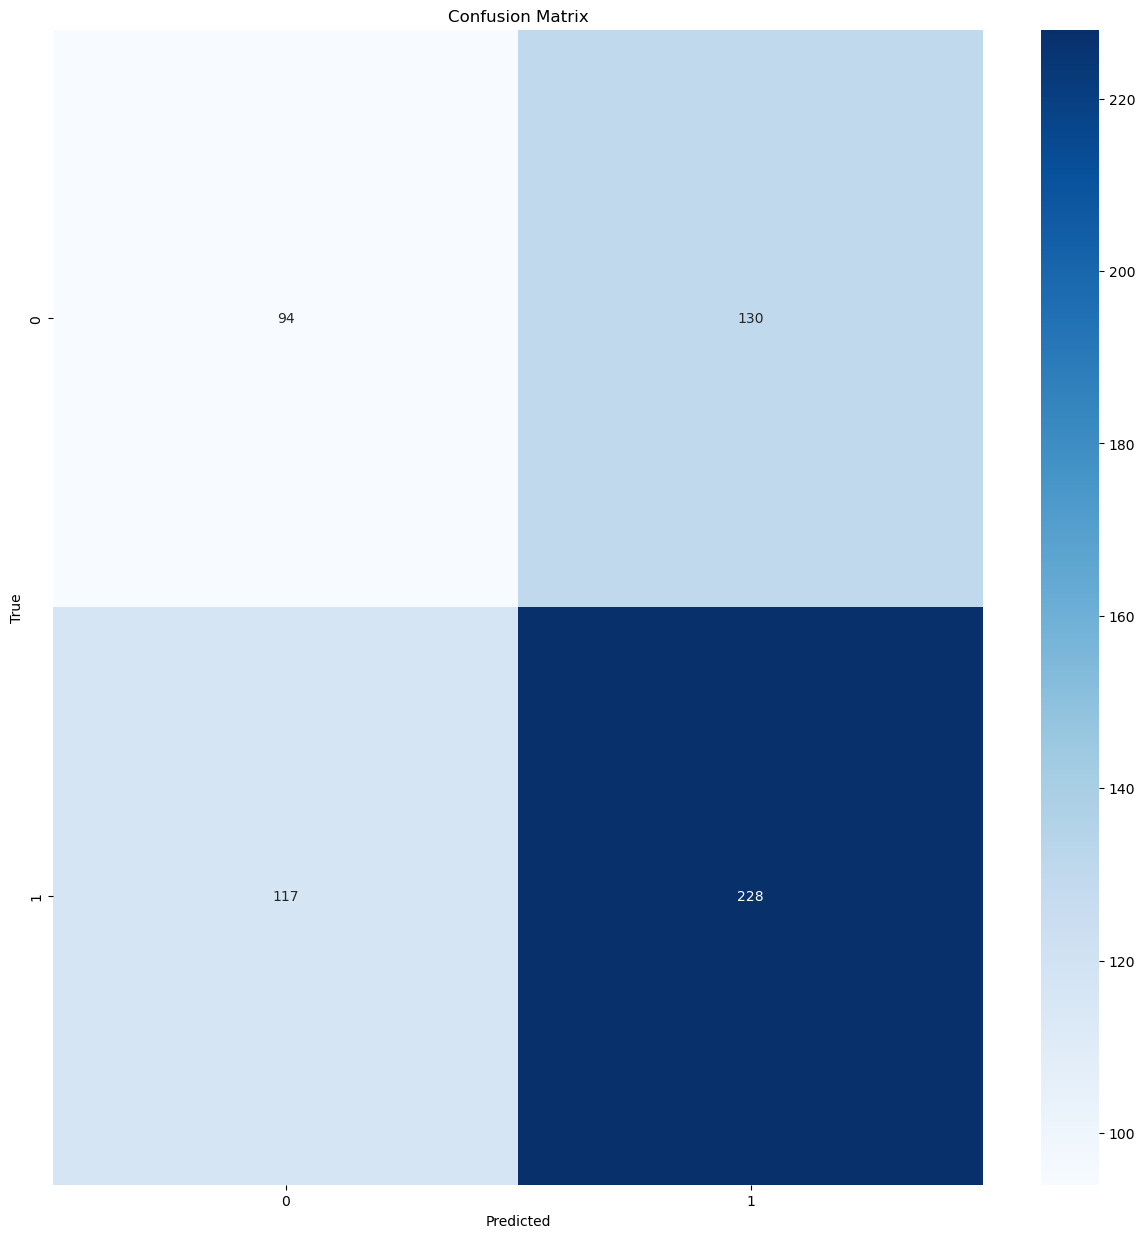

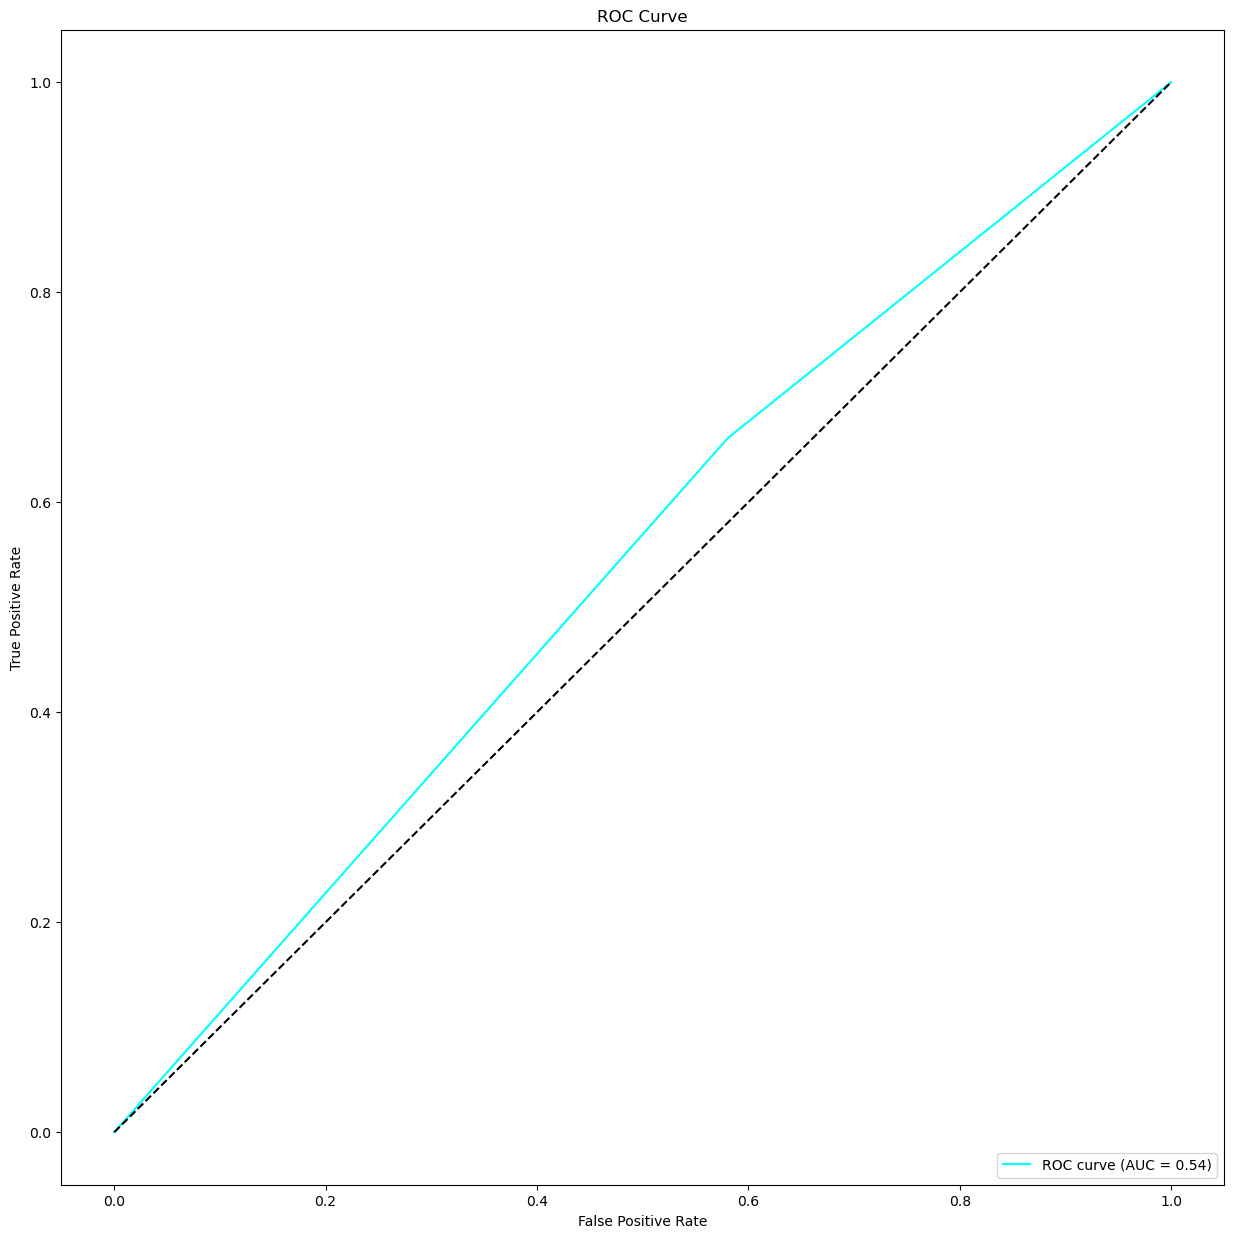

              precision    recall  f1-score   support

           0       0.45      0.42      0.43       224
           1       0.64      0.66      0.65       345

    accuracy                           0.57       569
   macro avg       0.54      0.54      0.54       569
weighted avg       0.56      0.57      0.56       569



In [9]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=50, multilabel=multilabel, report=True)

In [10]:
# Train late fusion model
print("Training Late Fusion Model:")
device = "cuda"

train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=50, multilabel=multilabel, report=True, device = device)

Training Late Fusion Model:
Model Memory Usage: 0.19 MB
The number of parameters of the model are: 49794


STAGE:2024-03-19 16:28:39 3013688:3013688 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


> /media/enc/vera1/sebastian/codes/Foundational-Multimodal-Fusion-Benchmark/src/classifiers_cpu_metrics.py(822)train_late_fusion()
    820                     optimizer.zero_grad()
    821                     import pdb;pdb.set_trace()
--> 822                     outputs = model(text, image)
    823                     loss = criterion(outputs, labels)
    824                     loss.backward()



ipdb>  text


tensor([], device='cuda:0', size=(64, 0))


ipdb>  image


tensor([[-1.8218,  0.9166,  3.6117,  ...,  0.5375,  1.1347, -1.0398],
        [-1.1203,  0.5992,  2.6870,  ..., -1.9306, -0.3385, -1.1738],
        [-0.4032,  3.3822,  3.1510,  ..., -0.7096,  0.0145, -3.2349],
        ...,
        [-0.2041,  0.4880,  4.3211,  ..., -0.7200,  0.3784, -1.5505],
        [-0.4284,  1.4132,  5.3352,  ...,  0.7014, -0.1423, -0.4425],
        [-1.1940,  0.9098,  3.1944,  ..., -0.2694, -0.2346, -1.0931]],
       device='cuda:0')


ipdb>  batch['text']


tensor([], size=(64, 0))


ipdb>  exit


STAGE:2024-03-19 16:40:57 3013688:3013688 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-03-19 16:40:57 3013688:3013688 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
